### Spaceship Titanic은 titanic과 비슷한 상황이 1000년 이후에 벌어진 것을 말합니다. 이진 분류 모델을 XGBoost를 사용하여 모델링을 해보세요.

- 데이터 링크 : https://drive.google.com/drive/folders/1UTft-BlveN5AUN5vMd2yoN4xzvvHRC5D?usp=drive_link

- 데이터 설명 : https://www.kaggle.com/competitions/spaceship-titanic/data

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

## 1. 라이브러리, 데이터 불러오기

In [3]:
# 데이터분석 4종 세트
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split

In [158]:
# 데이터를 불러옵니다.
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

## 2. EDA

- 데이터에서 찾아야 하는 기초적인 내용들을 확인합니다.


- 데이터 설명을 자세히 읽고, feature engineering에 필요한 여러가지 특징들을 찾아봅시다.

In [6]:
## 1. 결측치 체크  --> 특정 column이 많은 결측치를 포함하고 있는지!
# -> 'PassengerId' 와 'Transported' 를 제외한 모든 columns 가 결측치를 포함함
train.info()
## 2. dtype이 object인 column들 체크 (str)
# -> 'PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Name'
print('------------------Object Columns--------------------')
print(train.columns[train.dtypes == 'object'])
## 3. target value 정보를 체크 -----> class imbalance 체크! (이진분류) 10:1 이상인 경우
# -> 약 5:5 
print('---------------Target Imbalance Check---------------')
train.Transported.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
------------------Object Columns--------------------
Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP',
       'N

Transported
True     4378
False    4315
Name: count, dtype: int64

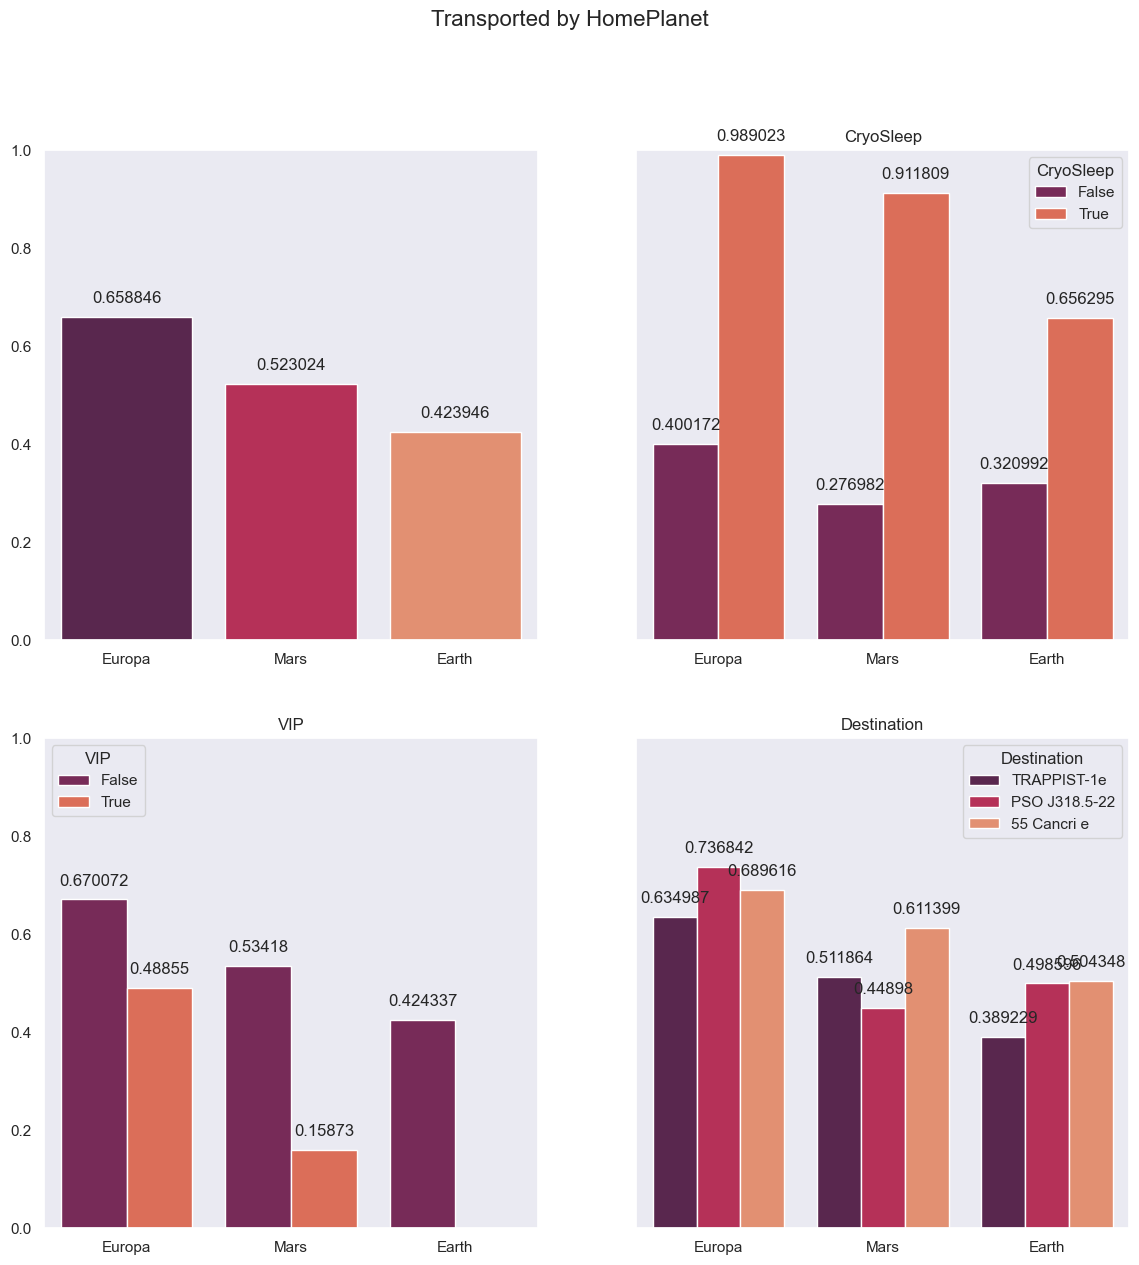

In [20]:
## 4. HomePlanet이 다르면, Transported되는 정도가 다른지 체크해보세요.
mean_values = train.groupby('HomePlanet')['Transported'].mean().sort_values(ascending=False)
def transported_by_HomePlanet(ax, hue=None):
    sns.barplot(data=train, x='HomePlanet', y='Transported', palette="rocket", hue=hue, errorbar=None, order=mean_values.index, ax=ax)
    ax.set_ylim(0.0, 1.0)
    ax.set(xlabel='', ylabel='', title=hue)
    for i in ax.containers:
        ax.bar_label(i, padding=8)

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharey=True ,figsize=(14, 14))
f.suptitle('Transported by HomePlanet', fontsize=16)
transported_by_HomePlanet(ax=ax1)
transported_by_HomePlanet(ax=ax2, hue='CryoSleep')
transported_by_HomePlanet(ax=ax3, hue='VIP')
transported_by_HomePlanet(ax=ax4, hue='Destination')


<Axes: xlabel='Group_Num', ylabel='Transported'>

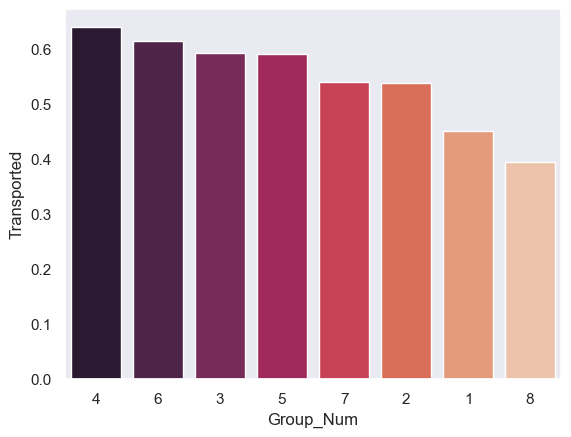

In [159]:
## 5. passengerId는 group_num(4자리, usually family but not always) + id(그룹내에서 2자리)로 구성되어 있습니다. group_num에 따라서 Transported가 차이를 가지는지 체크해보세요.
train['Group'] = train.PassengerId.str.slice(0,4)
train['Group_Num'] = train.groupby('Group')['Group'].transform('size')
mean_values = train.groupby('Group_Num')['Transported'].mean().sort_values(ascending=False)
sns.barplot(data=train, x='Group_Num', y='Transported', palette="rocket", errorbar=None, order=mean_values.index)

이런 식으로 여러가지 그래프를 그려가며, 데이터에 대한 인사이트를 얻습니다!

### 3. 전처리

#### 결측치 처리

In [160]:
## 6. group 정보를 passenger_Id로부터 추출해서, group_size가 4 이상인 고객들은 in_large_group 이라는 column에 1,
##                                     나머지는 0으로 하는 feature를 만들어보세요!
train['Middle_group'] = train.Group_Num.apply(lambda x: 0 if x in (1,2,7,8) else 1)
train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Group_Num,Middle_group
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,1,0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,1,0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,2,0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,2,0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False,9276,1,0
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False,9278,1,0
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True,9279,1,0
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False,9280,2,0


In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
 14  Group         8693 non-null   object 
 15  Group_Num     8693 non-null   int64  
 16  Middle_group  8693 non-null   int64  
dtypes: bool(1), float64(6), int64(2), object(8)
memory usage: 1.1+ MB


In [36]:
## 7. categorical feature에 해당하는 column 대해서는 mode를 계산해서 채워주고, numeric feature에 대해서는 mean을 계산해서 채워주세요.
train.HomePlanet = train.HomePlanet.fillna(train.HomePlanet.mode().values[0])
train.CryoSleep = train.CryoSleep.fillna(train.CryoSleep.mode().values[0])
train.Cabin = train.Cabin.str.slice(0,1,1)
train.Cabin = train.Cabin.fillna(train.Cabin.mode().values[0])
train.Destination = train.Destination.fillna(train.Destination.mode().values[0])
train.Age = train.Age.fillna(train.Age.median())
train.VIP = train.VIP.fillna(train.VIP.mode().values[0])
train = train.drop(columns=['PassengerId', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'Group', 'Group_Num'])
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8693 non-null   object 
 1   CryoSleep     8693 non-null   bool   
 2   Cabin         8693 non-null   object 
 3   Destination   8693 non-null   object 
 4   Age           8693 non-null   float64
 5   VIP           8693 non-null   bool   
 6   Transported   8693 non-null   bool   
 7   Middle_group  8693 non-null   int64  
dtypes: bool(3), float64(1), int64(1), object(3)
memory usage: 365.2+ KB


In [38]:
## 8. 결측치 처리가 완료된 모든 column들에 대해서 One-Hot encoding을 수행해주세요.
train = pd.get_dummies(data=train, columns=["HomePlanet", "Cabin", "Destination"])
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CryoSleep                  8693 non-null   bool   
 1   Age                        8693 non-null   float64
 2   VIP                        8693 non-null   bool   
 3   Transported                8693 non-null   bool   
 4   Middle_group               8693 non-null   int64  
 5   HomePlanet_Earth           8693 non-null   bool   
 6   HomePlanet_Europa          8693 non-null   bool   
 7   HomePlanet_Mars            8693 non-null   bool   
 8   Cabin_A                    8693 non-null   bool   
 9   Cabin_B                    8693 non-null   bool   
 10  Cabin_C                    8693 non-null   bool   
 11  Cabin_D                    8693 non-null   bool   
 12  Cabin_E                    8693 non-null   bool   
 13  Cabin_F                    8693 non-null   bool 

### 4. 학습 데이터 분할

In [40]:
#### 아래 train / validation을 고정해주세요!! ####

X = train.drop(columns='Transported') # feature vector
y = train.Transported                 # target value

# 트테트테
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(6954, 18) (6954,) (1739, 18) (1739,)


### 5. 학습 및 평가

In [151]:
### 9. XGBClassifier를 학습해보세요. hyper-parameter는 자유롭게 넣어주세요.
model = XGBClassifier(
    n_estimators= 60, # 55 65
    max_depth= 6, # 6 7
    colsample_bynode= 0.8, # 0.7 0.8
    learning_rate= 0.05, # 0.05 0.1
    reg_lambda= 1, # 1, 3
    random_state= 42,
)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=0.8,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=60, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [152]:
print("Prediction")
pred_train = model.predict(X_train)
pred_val = model.predict(X_val)

train_score = accuracy_score(y_train, pred_train)
val_score = accuracy_score(y_val, pred_val)

print("Train Score : %.4f" % train_score)
print("Validation Score : %.4f" % val_score)

Prediction
Train Score : 0.7535
Validation Score : 0.7407


### 6. Hyper-parameter Tuning

 - 이 링크를 참고하세요. https://xgboost.readthedocs.io/en/stable/parameter.html

 - 이 링크도 참고하세요. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [153]:
from sklearn.model_selection import GridSearchCV

### 10. GridSearchCV 함수를 공부해서, 아래 param_grid를 채워넣고 검증 성능이 높은 hyper-parameter 조합을 찾아보세요.

param_grid = {
    'n_estimators' : [55, 65],
    'max_depth' : [6, 7],
    'colsample_bynode' : [0.7, 0.8],
    'learning_rate' : [0.05, 0.1],
    'reg_lambda' : [1, 3],
    'random_state' : [42]
} # 3 x 2 x 2 x 2 x 2 = 48개.

gcv = GridSearchCV(estimator=XGBClassifier(), param_grid=param_grid, cv=5, verbose=1)

gcv.fit(X_train, y_train)
print("Best Estimator : ", gcv.best_estimator_)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Estimator :  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=0.7,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=65, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)


In [154]:
print("Prediction with Best Estimator")
gcv_pred_train = gcv.predict(X_train)
gcv_pred_val = gcv.predict(X_val)

gcv_train_score = accuracy_score(y_train, gcv_pred_train)
gcv_val_score = accuracy_score(y_val, gcv_pred_val)

print("Train ACC Score : %.4f" % gcv_train_score)
print("Validation ACC Score : %.4f" % gcv_val_score)

Prediction with Best Estimator
Train ACC Score : 0.7554
Validation ACC Score : 0.7292


In [166]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [183]:
test = pd.read_csv('./data/test.csv')
test['Group'] = test.PassengerId.str.slice(0,4)
test['Group_Num'] = test.groupby('Group')['Group'].transform('size')
test['Middle_group'] = test.Group_Num.apply(lambda x: 0 if x in (1,2,7,8) else 1)
test.HomePlanet = test.HomePlanet.fillna(train.HomePlanet.mode().values[0])
test.CryoSleep = test.CryoSleep.fillna(train.CryoSleep.mode().values[0])
test.Cabin = test.Cabin.str.slice(0,1,1)
test.Cabin = test.Cabin.fillna(train.Cabin.mode().values[0])
test.Destination = test.Destination.fillna(train.Destination.mode().values[0])
test.Age = test.Age.fillna(train.Age.median())
test.VIP = test.VIP.fillna(train.VIP.mode().values[0])
test = test.drop(columns=['PassengerId', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'Group', 'Group_Num'])
test = pd.get_dummies(data=test, columns=["HomePlanet", "Cabin", "Destination"])
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CryoSleep                  4277 non-null   bool   
 1   Age                        4277 non-null   float64
 2   VIP                        4277 non-null   bool   
 3   Middle_group               4277 non-null   int64  
 4   HomePlanet_Earth           4277 non-null   bool   
 5   HomePlanet_Europa          4277 non-null   bool   
 6   HomePlanet_Mars            4277 non-null   bool   
 7   Cabin_A                    4277 non-null   bool   
 8   Cabin_B                    4277 non-null   bool   
 9   Cabin_C                    4277 non-null   bool   
 10  Cabin_D                    4277 non-null   bool   
 11  Cabin_E                    4277 non-null   bool   
 12  Cabin_F                    4277 non-null   bool   
 13  Cabin_G                    4277 non-null   bool 

In [184]:
gcv_pred_test = gcv.predict(test)
gcv_pred_test

array([1, 0, 1, ..., 1, 0, 0])

In [194]:
test_result = pd.read_csv('./data/test.csv')
test_result = test_result[['PassengerId']]
test_result['Transported'] = gcv_pred_test
test_result['Transported'] = test_result['Transported'].apply(lambda x: True if x else False)
test_result

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,False
4,0023_01,False
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,False


In [191]:
test_result.to_csv("./result_submission_guide.csv", index=False)